In [1]:
import numpy as np
import torch
from torch import optim
from torch import distributions as dist
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pytorch_lightning as pl   # Equivalent of Keras but for Pytorch

from plot.plot_hist_loss import plot_loss
from plot.plot_posterior import plot_posterior
from simulate.simulate import simulate
from inference.flows import NormalizingFlow
from inference.loss import LossTeaching

In [2]:
sns.set()

In [3]:
%config InlineBackend.figure_format = "retina"

In [4]:
def plot_results(mu_samples, log_var_samples, 
                 obs_mu, obs_sigma, 
                 true_mu, true_sigma,
                 alpha_scatter=0.3, 
                 alpha_pdf=0.1):
    
    true_log_var = np.log(true_sigma**2)
    obs_log_var = np.log(obs_sigma**2)
    
    sigma_samples = torch.exp(0.5*log_var_samples)
    
    fig, axes = plt.subplots(ncols=2, figsize=(16, 8))

    ax=axes[0]
    ax.set_title("Unconstrained space")
    ax.scatter(mu_samples, log_var_samples, alpha=alpha_scatter, color="C1")
    ax.scatter(true_mu, true_log_var, label="theoretic", facecolors='none', edgecolors='C0', s=80,
               linewidths=1,)
    ax.scatter(obs_mu, obs_log_var, label="observed", facecolors='none', edgecolors='C0', s=80,
               linewidths=3,)
    ax.set_xlabel("$\mu$")
    ax.set_ylabel("$\ln \sigma^2$")
    ax.legend()

    ax=axes[1]
    x = torch.linspace(-2, 10, 100).unsqueeze(0)
    
    pdf_true = dist.Normal(true_mu, true_sigma).log_prob(x).exp()
    pdf_sample = dist.Normal(mu_samples, sigma_samples).log_prob(x.unsqueeze(-1)).exp()

    ax.plot(x.squeeze(), pdf_sample.squeeze(), color="C1", alpha=alpha_pdf, label='inferred')
    ax.plot(x.squeeze(), pdf_true.squeeze(), color='C0', label="theoretic")
    # ax.hist(observations.data.numpy(), bins='auto', alpha=0.3, density=True, 
    #         color='C0', label="observed", zorder=1)

    handles, labels = ax.get_legend_handles_labels()
    labels, ids = np.unique(labels, return_index=True)
    handles = [handles[i] for i in ids]
    ax.legend(handles, labels,)
    ax.set_xlim(torch.min(x), torch.max(x));

In [5]:
n_obs = 100
true_mu = 4
true_sigma = 2 
torch.manual_seed(1234)
obs = dist.Normal(loc=true_mu, scale=true_sigma).sample((n_obs, ))

In [6]:
obs_mu = torch.mean(obs).item()
obs_sigma = torch.std(obs).item()
print(f"obs mu = {obs_mu:.2f}")
print(f"obs sigma = {obs_sigma:.2f}")

obs mu = 3.81
obs sigma = 1.97


In [7]:
n_dim = 2

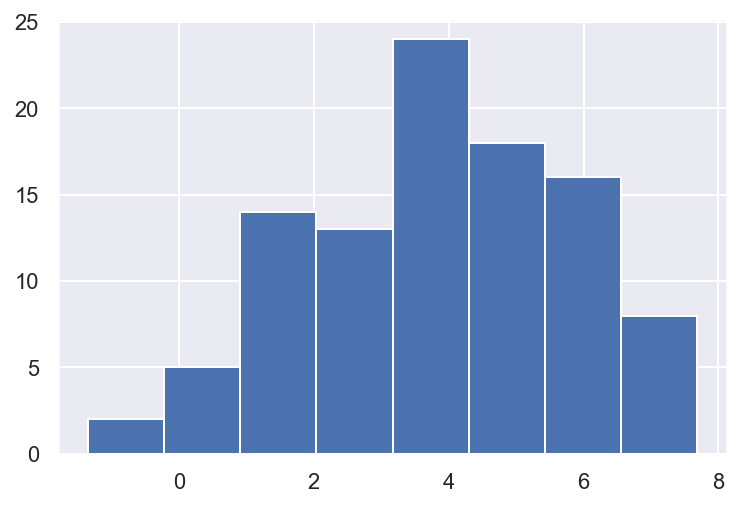

In [8]:
fig, ax = plt.subplots()
ax.hist(obs.data.numpy(), bins='auto');

# Model

In [26]:
class Model(pl.LightningModule):
    
    def __init__(self, n_dim, flow_length, total_n_obs=100, n_sample=40, init_lr=0.01):
        
        super().__init__()
        self.flow = NormalizingFlow(dim=n_dim, flow_length=flow_length)
        self.init_lr = init_lr
        self.n_sample = n_sample
        self.total_n_obs = total_n_obs
        
    def configure_optimizers(self):
        
        optimizer = optim.Adam(
            self.parameters(),
            lr=self.init_lr)
        return optimizer
    
    def training_step(self, batch, batch_idx):
        
        x, _ = batch
        
        z0 = self.flow.sample_base_dist(self.n_sample)
        zk, log_q0, log_sum_det = self.flow(z0) # shape: (n_sample, n_dim), (n_sample, ) (n_sample, ) 
    
        mu, log_var = zk.T
        sigma = torch.exp(0.5 * log_var)
        lls =  dist.Normal(mu, sigma).log_prob(x).sum(axis=0)  # shape: (n_obs, n_sample) => (n_sample, )

        scale = self.total_n_obs / x.size(0)
        
        loss = (log_q0 - log_sum_det - scale*lls).mean()
        
        self.log('loss_epoch', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def generate_samples(self, n_sample):
        
        with torch.no_grad():
            z0 = self.flow.sample_base_dist(n_sample)  
            zk, prior_logprob, log_det = self.flow(z0)
        mu_samples, log_var_samples = zk.T
        
        return mu_samples, log_var_samples

In [27]:
import warnings
warnings.filterwarnings('ignore')

# Full batch

In [33]:
X_train = obs.unsqueeze(-1)
y_train = torch.zeros(obs.size(0))

In [34]:
train = torch.utils.data.TensorDataset(X_train, y_train)
trainloader = torch.utils.data.DataLoader(train, batch_size=X_train.size(0), num_workers=0)

model = Model(n_dim=2, flow_length=16)
trainer = pl.Trainer(max_epochs=500)
trainer.fit(model, trainloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type            | Params
-----------------------------------------
0 | flow | NormalizingFlow | 84    
-----------------------------------------
84        Trainable params
0         Non-trainable params
84        Total params
0.000     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

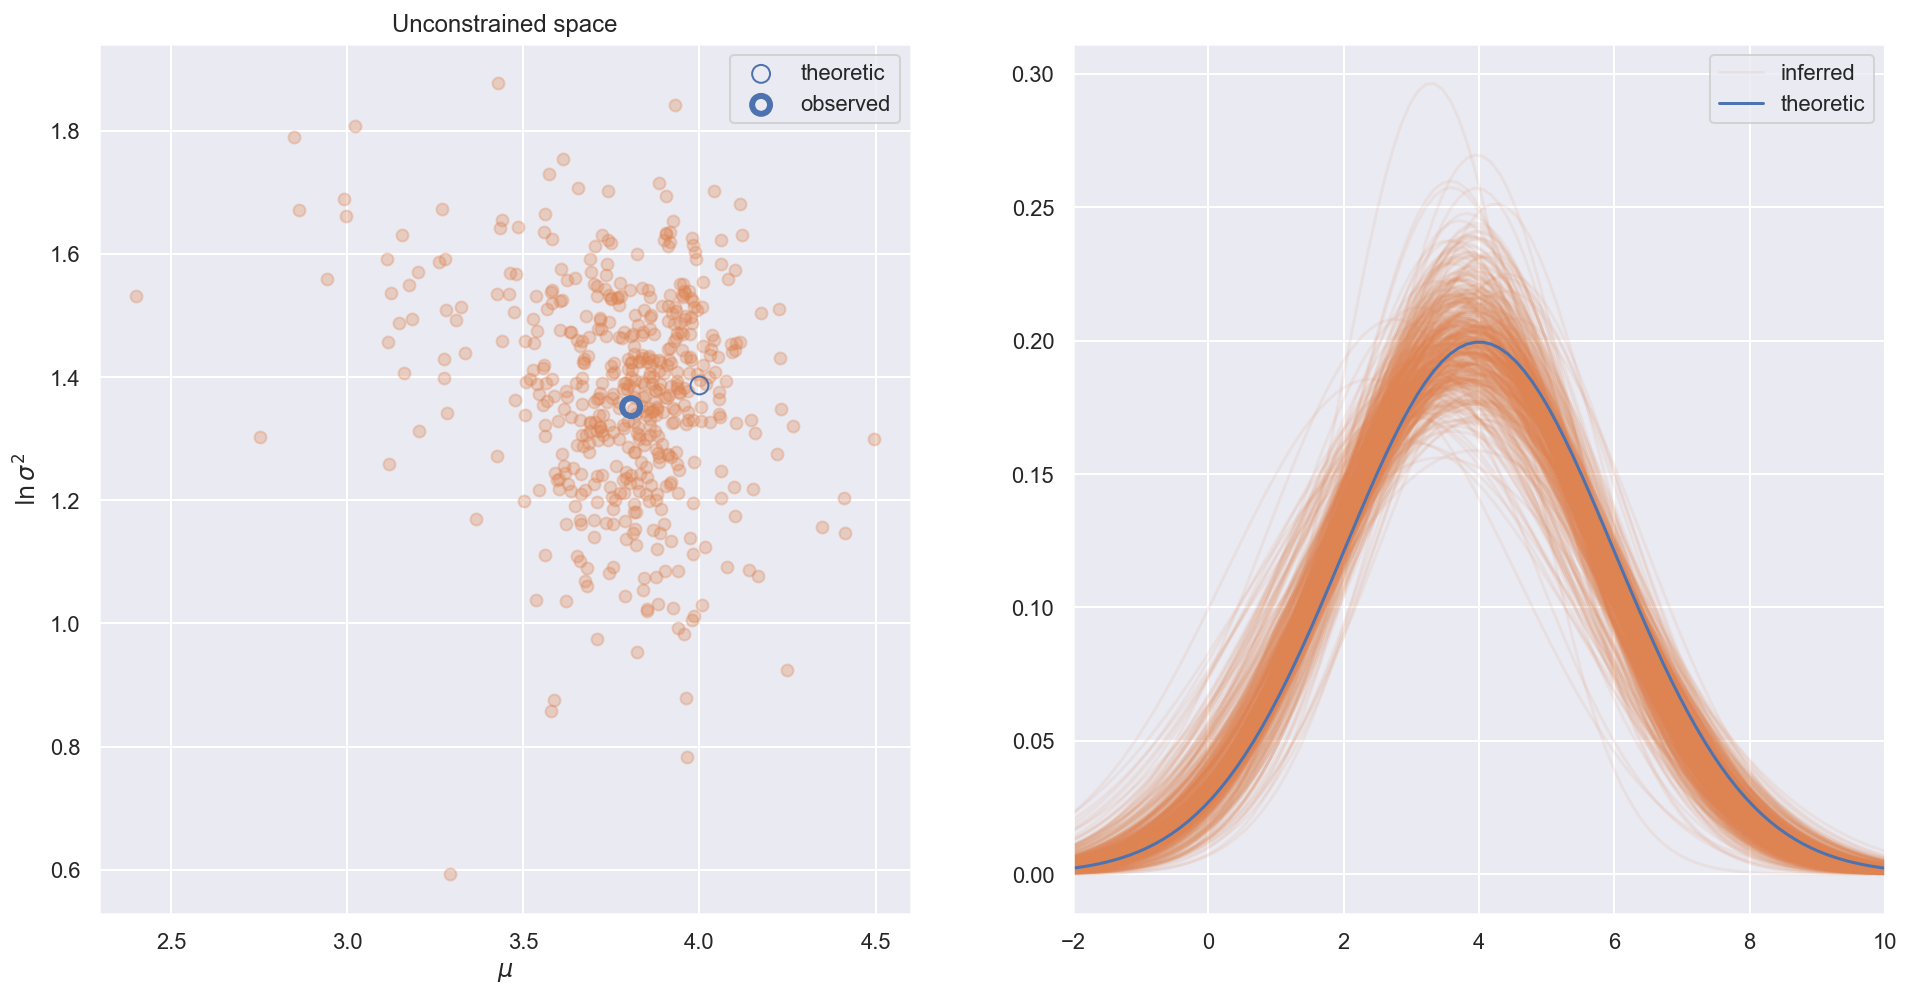

In [35]:
mu_samples, log_var_samples = model.generate_samples(n_sample=500)

plot_results(
    true_mu=true_mu, true_sigma=true_sigma, 
    obs_mu=obs_mu, obs_sigma=obs_sigma, 
    mu_samples=mu_samples, log_var_samples=log_var_samples)

# Minibatch

In [39]:
train = torch.utils.data.TensorDataset(X_train, y_train)
trainloader = torch.utils.data.DataLoader(train, batch_size=1, num_workers=0)

model = Model(n_dim=2, flow_length=40)
trainer = pl.Trainer(max_epochs=500)
trainer.fit(model, trainloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type            | Params
-----------------------------------------
0 | flow | NormalizingFlow | 204   
-----------------------------------------
204       Trainable params
0         Non-trainable params
204       Total params
0.001     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

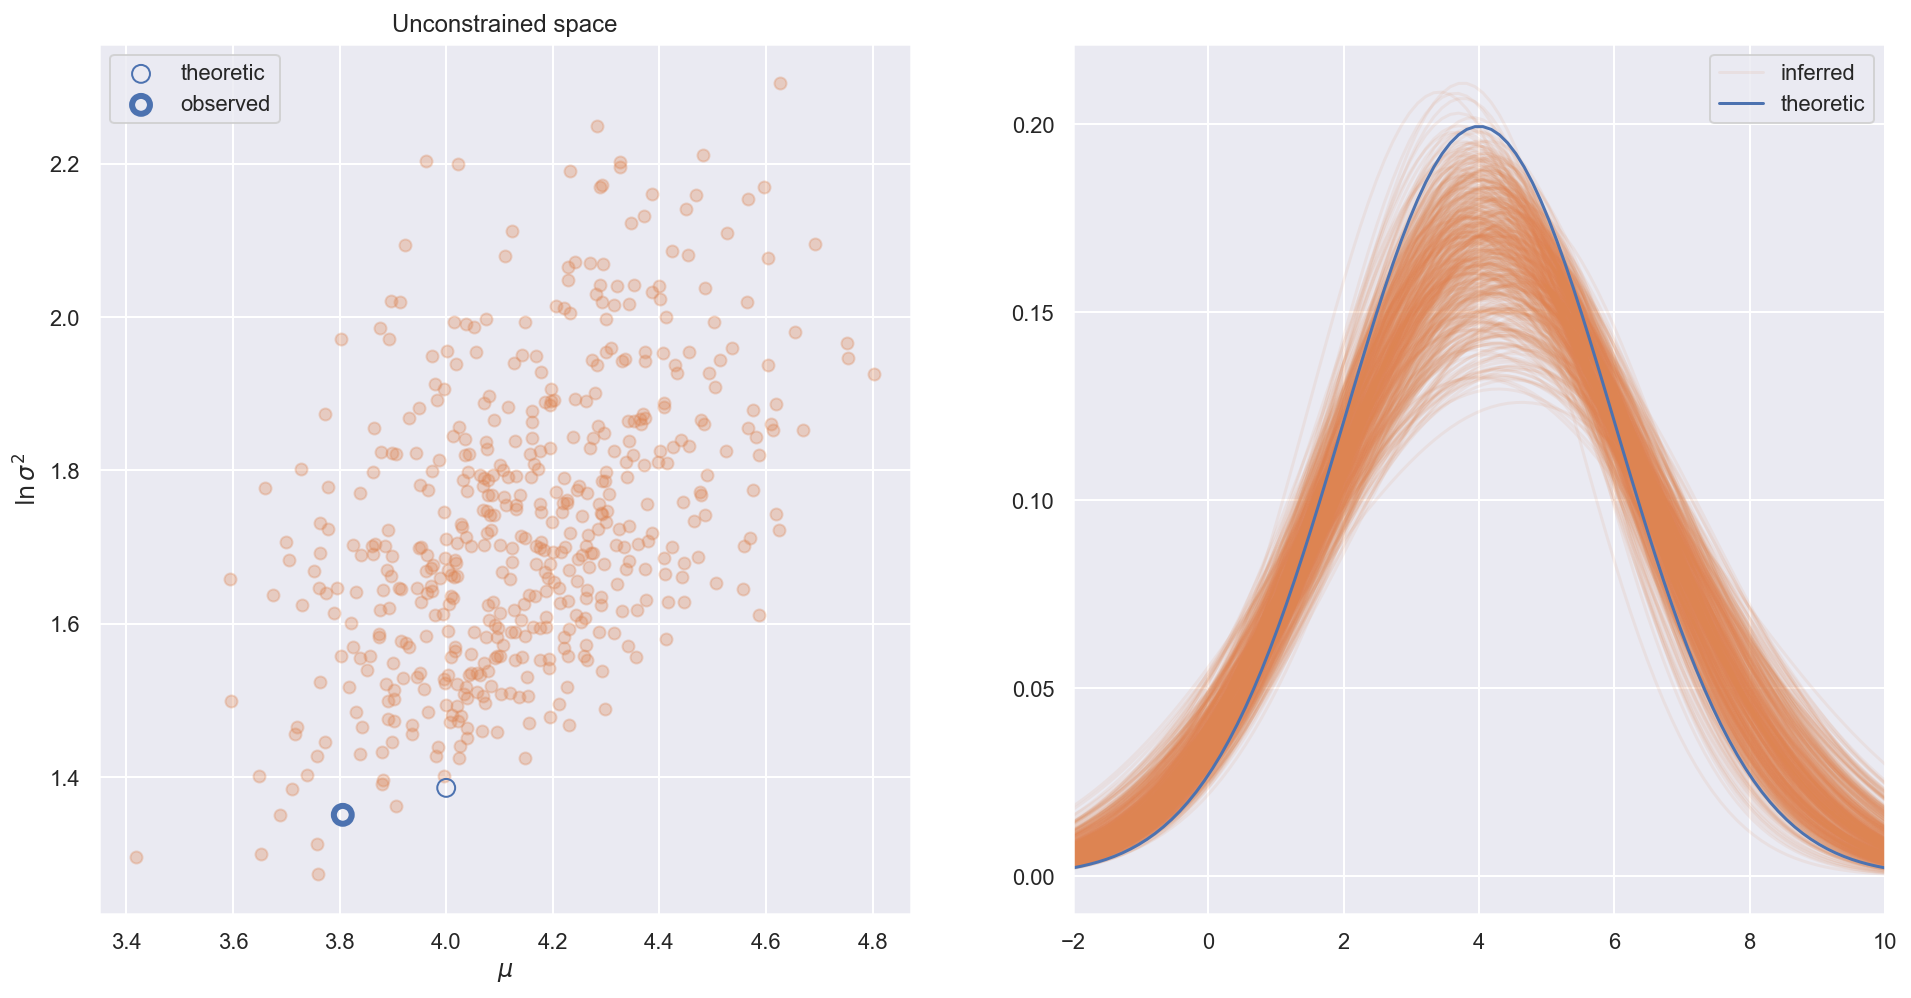

In [41]:
mu_samples, log_var_samples = model.generate_samples(n_sample=500)

plot_results(
    true_mu=true_mu, true_sigma=true_sigma, 
    obs_mu=obs_mu, obs_sigma=obs_sigma, 
    mu_samples=mu_samples, log_var_samples=log_var_samples)